In [30]:
pip install konlpy

In [31]:
pip install keras

In [32]:
pip install tensorflow

In [33]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [34]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7bb5dc3a2bd0>)

In [35]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [36]:
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [37]:
print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

(train) len : 150000
(test) len : 50000
(train) len : 146183
(test) len : 49158


In [38]:
train_data['label'].value_counts()

,count
label,
0,73342
1,72841


In [39]:
test_data['label'].value_counts()

,count
label,
1,24712
0,24446


In [40]:
train_data.isnull().sum()

,0
document,1
label,0


In [41]:
test_data.isnull().sum()

,0
document,1
label,0


In [42]:
# 결측치 제거
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [43]:
# 한글과 공백 제외 리뷰 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data.head()

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [44]:
# 빈 데이터 제거
train_data = train_data[train_data['document'].str.strip().astype(bool)]
test_data = test_data[test_data['document'].str.strip().astype(bool)]

print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

(train) len : 145393
(test) len : 48852


In [45]:
!apt-get install -y openjdk-11-jdk

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.environ["JAVA_HOME"] + "/bin"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [46]:
# 토큰화
okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어
X_train = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_train[:3]

100%|██████████| 145393/145393 [11:50<00:00, 204.60it/s]


[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [47]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

X_test[:3]

100%|██████████| 48852/48852 [04:23<00:00, 185.32it/s]


[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

In [48]:
# 희귀 단어 비율 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도가 3보다 작은 단어 수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도가 3보다 작은 단어의 등장 빈도의 총 합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어수 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print("희귀 단어 사용 비율:", (rare_freq / total_freq)*100)


단어수 : 43752
등장 빈도가 2번 이하인 희귀 단어 수: 24337
희귀 단어 사용 비율: 1.8715872104872904


In [49]:
# 인코딩
tokenizer = Tokenizer(total_cnt - rare_cnt + 1) # 희귀 단어 제거
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [50]:
# 희귀 단어 제거 후 다시 결측치 제거
drop_train = [i for i, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = [x for i, x in enumerate(X_train) if i not in drop_train]
y_train = np.array([y for i, y in enumerate(y_train) if i not in drop_train])

print(len(X_train))
print(len(y_train))


145162
145162


리뷰의 평균 길이 : 10.812485361182679


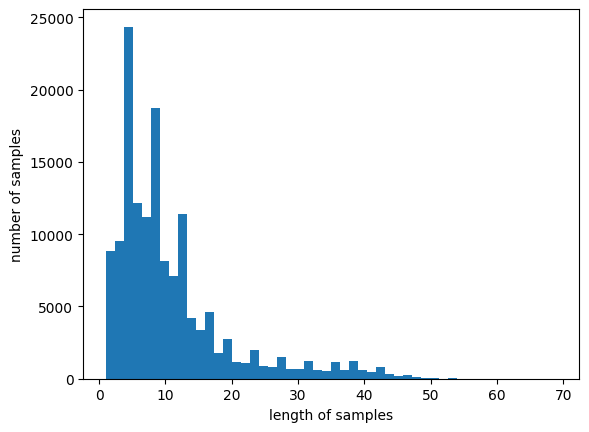

In [51]:
# 리뷰 길이 분포
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
# 길이 이하 리뷰 비율
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(20, X_train)
below_threshold_len(25, X_train)
below_threshold_len(30, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 88.18836885686336
전체 샘플 중 길이가 25 이하인 샘플의 비율: 91.77884019233684
전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [53]:
# 패딩
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [54]:
!pip install keras-tuner

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

# Bi-LSTM 모델 정의
def build_model(hp):
    model = Sequential()
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100, 200])
    model.add(Embedding(total_cnt - rare_cnt + 1, embedding_dim))
    units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    model.add(Bidirectional(LSTM(units)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    optimizer = Adam() if optimizer_name == 'adam' else RMSprop()

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [56]:
# Attention Layer 정의
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [57]:
# Attention 결합 모델
def build_model_with_attention(hp):
    model = Sequential()
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100, 200])
    model.add(Embedding(total_cnt - rare_cnt + 1, embedding_dim))
    units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Attention())
    model.add(Dense(1, activation='sigmoid'))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    optimizer = Adam() if optimizer_name == 'adam' else RMSprop()

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [58]:
# 튜닝 및 평가 함수
def train_and_evaluate(model_builder, project_name):
    tuner = RandomSearch(
        model_builder,
        objective='val_accuracy',
        max_trials=3,
        executions_per_trial=1,
        directory='tuner_results',
        project_name=project_name,
        overwrite=True
    )
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    tuner.search(
        X_train, y_train,
        epochs=5,
        validation_split=0.2,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
    return best_model, acc

In [59]:
data_ratios = [0.3, 0.5, 0.7, 1.0]
results = []

for ratio in data_ratios:
    print(f"\n=== 데이터 비율: {int(ratio * 100)}% ===")

    # 데이터 샘플링
    indices = np.random.choice(len(X_train), size=int(len(X_train)*ratio), replace=False)
    X_train_sample = X_train[indices]
    y_train_sample = y_train[indices]

    # 기본 Bi-LSTM 모델
    print("=== Base Bi-LSTM 모델 학습 ===")
    base_model, base_acc = train_and_evaluate(build_model, 'base_bilstm')

    # Attention 추가 Bi-LSTM 모델
    print("\n=== Bi-LSTM + Attention 모델 학습 ===")
    att_model, att_acc = train_and_evaluate(build_model_with_attention, 'bilstm_attention')

    print(f"기존 Bi-LSTM 정확도: {base_acc:.4f}")
    print(f"Bi-LSTM + Attention 정확도: {att_acc:.4f}")

    results.append((ratio, base_acc, att_acc))

    # 리뷰 길이별 정확도 비교
    length_bins = [0, 10, 20, 30]
    X_test_lens = np.sum(X_test > 0, axis=1)

    for i in range(len(length_bins)-1):
        idx = [j for j, l in enumerate(X_test_lens)
               if length_bins[i] < l <= length_bins[i+1]]
        if len(idx) == 0:
            continue
        acc = np.mean((att_model.predict(X_test[idx], verbose=0) > 0.5).flatten() == y_test[idx])
        print(f"{length_bins[i]+1}-{length_bins[i+1]} 단어 리뷰 정확도: {acc:.4f}")

    # # 리뷰 길이별 정확도 확인
    # length_bins = [0, 10, 20, 30]
    # X_test_lens = np.sum(X_test > 0, axis=1)  # 패딩 제외 실제 길이

    # for i in range(len(length_bins)-1):
    #     idx = [j for j, l in enumerate(X_test_lens) if length_bins[i] < l <= length_bins[i+1]]
    #     if len(idx) == 0:
    #        continue
    #     acc = np.mean((best_model.predict(X_test[idx])>0.5).flatten() == y_test[idx])
    #     print(f"{length_bins[i]+1}-{length_bins[i+1]} 길이 리뷰 정확도: {acc:.4f}")



Trial 3 Complete [00h 01m 28s]
val_accuracy: 0.8525126576423645

Best val_accuracy So Far: 0.8557159304618835
Total elapsed time: 00h 04m 28s
기존 Bi-LSTM 정확도: 0.8522
Bi-LSTM + Attention 정확도: 0.8522
1-10 단어 리뷰 정확도: 0.8457
11-20 단어 리뷰 정확도: 0.8633
21-30 단어 리뷰 정확도: 0.8720


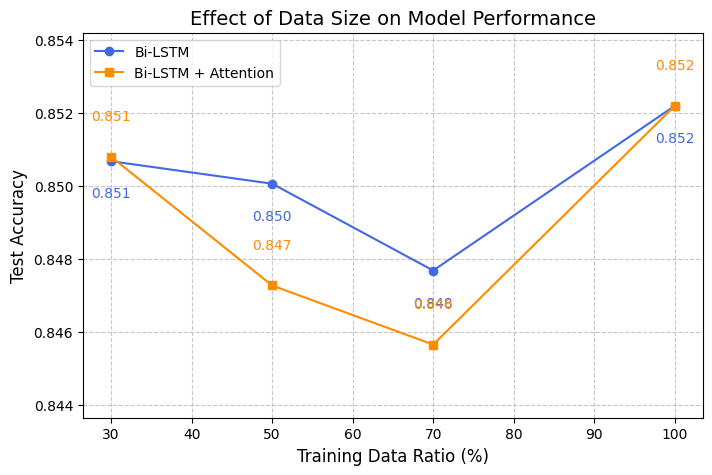

In [64]:
# 결과 시각화
import matplotlib.pyplot as plt

ratios = [int(r[0]*100) for r in results]
base_accs = [r[1] for r in results]
att_accs = [r[2] for r in results]

plt.figure(figsize=(8, 5))

# 두 모델 성능 곡선
plt.plot(ratios, base_accs, marker='o', label='Bi-LSTM', color='royalblue')
plt.plot(ratios, att_accs, marker='s', label='Bi-LSTM + Attention', color='darkorange')

# 제목 및 축
plt.title('Effect of Data Size on Model Performance', fontsize=14)
plt.xlabel('Training Data Ratio (%)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

min_acc = min(base_accs + att_accs)
max_acc = max(base_accs + att_accs)
plt.ylim(min_acc - 0.002, max_acc + 0.002)

for i in range(len(ratios)):
    plt.text(ratios[i], base_accs[i] - 0.001, f"{base_accs[i]:.3f}",
             ha='center', color='royalblue', fontsize=10)
    plt.text(ratios[i], att_accs[i] + 0.001, f"{att_accs[i]:.3f}",
             ha='center', color='darkorange', fontsize=10)

plt.show()




In [61]:
# 틀린 리뷰 샘플 확인
preds = (att_model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
wrong_idx = np.where(preds != y_test)[0]

print("\n틀린 리뷰 샘플 예시:")
for i in wrong_idx[:5]
    print(f"\n리뷰: {test_data.iloc[i]['document']}")
    print(f"실제 라벨: {y_test[i]}, 예측값: {preds[i]}")

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
틀린 리뷰 샘플 예시:
 15                                      소위 ㅈ문가라는 평점은 뭐냐
25    괜히 나올 때 어미 알 건드려서 긁어 부스름 만들었다는 분이 저 아래 보이던데 영화...
31                                             안보면 후회ㅠㅠ
37                                       북괴는 우리의 주적일뿐이다
39                               셰익스피어는 셰익스피어고 이영화는 이영화
Name: document, dtype: object
[실제: 1 | 예측 확률: 0.187] → 소위 ㅈ문가라는 평점은 뭐냐
[실제: 1 | 예측 확률: 0.129] → 괜히 나올 때 어미 알 건드려서 긁어 부스름 만들었다는 분이 저 아래 보이던데 영화 제대로 안 봤네 알이 딱 까지면서 새끼가 나오려 했음 그냥 가면 그 놈 한테 당했을 것임 한 놈 두 놈 막 나올 게 뻔했으니 작살낼 수 밖에 없었다
[실제: 1 | 예측 확률: 0.471] → 안보면 후회ㅠㅠ
[실제: 0 | 예측 확률: 0.571] → 북괴는 우리의 주적일뿐이다
[실제: 0 | 예측 확률: 0.880] → 셰익스피어는 셰익스피어고 이영화는 이영화


In [62]:
# 감성 예측 함수
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True)  # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence])  # 인코딩
    pad_new = pad_sequences(encoded, maxlen=max_len)  # 패딩
    score = float(att_model.predict(pad_new))  # 예측

    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

# 예측 테스트
sentences = [
    "이 영화 개꿀잼 ㅋㅋㅋ",
    "이 영화 핵노잼 ㅠㅠ",
    "연기가 정말 훌륭했어요",
    "스토리가 지루해서 잠옴",
    "개노잼이네 ㅋㅋ"
]

for s in sentences:
    sentiment_predict(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
85.92% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
97.84% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
98.15% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/tmp/ipython-input-2402917555.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(best_model.predict(pad_new))  # 예측


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
99.50% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
99.08% 확률로 부정 리뷰입니다.

